In [3]:
import pandas as pd
import numpy as np
import copy
import util
import datetime

In [4]:
import importlib

In [5]:
importlib.reload(util)

<module 'util' from '/Users/hylei/fyp/A-Hybrid-Approach-for-AID/util.py'>

# Data Description

Now we have three preprocessed files: `cleaned_incidents.csv`, `concat_1.csv` and `stations-i880n.csv`.

The usage of each file:

`cleaned_incidents.csv`: labeled incidents with upstream and downstream stations. <br>
`concat_1.csv`: speed, flow and occupancy information for each detector station in the first batch, across one year. <br>
`stations-i880n.csv`: list of detector stations.

In [4]:
incidents = pd.read_csv("data/I88N-processed/cleaned_incidents.csv")
data = pd.read_csv("data/I88N-processed/concat_1.csv")
stations = pd.read_csv("data/I88N-processed/stations-i880n.csv")

In [5]:
incidents.head(5)

,ID,Date,Time,Duration,Upstream,Upstream_Idx,Downstream,Downstream_Idx,Start DateTime,End DateTime,Rounded SDT,Rounded EDT
0,16917196,2017-01-01,02:14:00,0 days 00:14:00.000000000,400765,97.0,400844.0,98.0,2017-01-01 02:14:00,2017-01-01 02:28:00,2017-01-01 02:15:00,2017-01-01 02:30:00
1,16917233,2017-01-01,02:44:00,0 days 00:06:00.000000000,400309,30.0,400417.0,31.0,2017-01-01 02:44:00,2017-01-01 02:50:00,2017-01-01 02:45:00,2017-01-01 02:50:00
2,16917615,2017-01-01,09:25:00,0 days 00:12:00.000000000,408134,61.0,400685.0,62.0,2017-01-01 09:25:00,2017-01-01 09:37:00,2017-01-01 09:25:00,2017-01-01 09:35:00
3,16917677,2017-01-01,10:59:00,0 days 00:43:00.000000000,401888,38.0,400137.0,39.0,2017-01-01 10:59:00,2017-01-01 11:42:00,2017-01-01 11:00:00,2017-01-01 11:40:00
4,16917744,2017-01-01,11:52:00,0 days 00:09:00.000000000,408135,57.0,417665.0,58.0,2017-01-01 11:52:00,2017-01-01 12:01:00,2017-01-01 11:50:00,2017-01-01 12:00:00


In [6]:
data.head(5)

,Unnamed: 0,Station ID,Date,Time,Occupancy,Flow,Speed
0,0,408907,2017-01-01,00:00:00,2.1,95.0,68.8
1,1,408907,2017-01-01,00:05:00,2.0,91.0,68.4
2,2,408907,2017-01-01,00:10:00,2.0,91.0,68.4
3,3,408907,2017-01-01,00:15:00,1.9,86.0,68.5
4,4,408907,2017-01-01,00:20:00,1.8,82.0,68.5


In [7]:
stations.head(5)

,Unnamed: 0,Fwy,District,County,City,CA PM,Abs PM,Length,ID,Name,Lanes,Type,Sensor Type,HOV,MS ID,IRM
0,0,I880-N,4,Santa Clara,NaN,0.31,0.31,0.425,408907,SB/NB 280 rm-n-fly/diag,3,Mainline,loops,No,DT596,L3-N-37-880-00031
1,1,I880-N,4,Santa Clara,NaN,0.54,0.54,0.510,400951,Stevens Creek Blvd,4,Mainline,loops,No,DT938,L4-N-37-880-00054
2,2,I880-N,4,Santa Clara,San Jose,1.33,1.33,0.750,400057,Bascom Ave rm-n-diag,3,Mainline,loops,No,DT960,L3-N-37-880-00133
3,3,I880-N,4,Santa Clara,San Jose,2.04,2.04,0.685,400147,The Alameda rm-n-loop,3,Mainline,loops,No,DT963,L3-N-37-880-00204
4,4,I880-N,4,Santa Clara,San Jose,2.7,2.70,0.735,400343,Coleman Ave rm-n-diag,3,Mainline,loops,No,DT082,L3-N-37-880-00270


Transform date time format to datetime to facilitate comparison: this may take a while.

In [56]:
incidents["Date"] = incidents["Date"].apply(lambda x: pd.to_datetime(x).date())
incidents["Time"] = incidents["Time"].apply(lambda x: pd.to_datetime(x).time())
data["Date"] = data["Date"].apply(lambda x: pd.to_datetime(x).date())
data["Time"] = data["Time"].apply(lambda x: pd.to_datetime(x).time())

In [9]:
incidents["Rounded SDT"] = incidents["Rounded SDT"].apply(lambda x: pd.to_datetime(x))
incidents["Rounded EDT"] = incidents["Rounded EDT"].apply(lambda x: pd.to_datetime(x))

Write an algorithm: given a detector station, construct a feature vector $X$ consisting of first 8 month's data.  Then we can call `TSA_train(X)` to return the best alpha.

In [11]:
feature_list = ["Occupancy", "Speed", "Flow"]

In [57]:
def TSA_construct_X(incidents, data, station_id, feature_list, start_date, end_date):
    days = data["Date"].unique()
    days = [day for day in days if (day >= start_date and day < end_date)]
    # check affected days
    affected_incidents = incidents.loc[incidents["Upstream"].isin([station_id]) | incidents["Downstream"].isin([station_id])]
    affected_days = affected_incidents["Date"].unique()
    # get unaffected days for station i
    train_date = [day for day in days if day not in affected_days]
    
    normal_train_data = data.loc[data["Station ID"].isin([station_id]) & data["Date"].isin(train_date)]
    
    return df_to_X(normal_train_data, feature_list)

In [58]:
X = TSA_construct_X(incidents, data, 400057, feature_list, datetime.date(2017, 1, 1), datetime.date(2017, 9, 1))

In [59]:
best_alpha, best_S1, best_S2, best_Y = TSA_train(X)

Variable 0:
0.0: 7.153835840658964
0.001: 7.161766253259109
0.002: 7.108607686707108
0.003: 7.060048829135211
0.004: 7.013136931423273
0.005: 6.964804856790735
0.006: 6.9162311490937665
0.007: 6.8660127609471395
0.008: 6.813681986596248
0.009000000000000001: 6.759400674576657
0.01: 6.703426491407142
0.011: 6.645895757241828
0.012: 6.587296070937664
0.013000000000000001: 6.527869862841802
0.014: 6.468080909176776
0.015: 6.408123841641723
0.016: 6.348424364750488
0.017: 6.289217375767576
0.018000000000000002: 6.230682720366038
0.019: 6.172994532130052
0.02: 6.116267622887778
0.021: 6.06063547963756
0.022: 6.006208466823852
0.023: 5.952982294633768
0.024: 5.901008703351169
0.025: 5.8503228766028625
0.026000000000000002: 5.8009092400550974
0.027: 5.752715205971189
0.028: 5.705830445277013
0.029: 5.660147975469558
0.03: 5.615610351224838
0.031: 5.5723352673653475
0.032: 5.530082975998923
0.033: 5.488950973194767
0.034: 5.448991342911032
0.035: 5.409820207447248
0.036000000000000004: 5.37177

0.302: 2.939357875950803
0.303: 2.937083546607929
0.304: 2.9348398848626287
0.305: 2.9325854262613738
0.306: 2.930351383430129
0.307: 2.92813958770615
0.308: 2.9259379942599795
0.309: 2.923753430301874
0.31: 2.9216027653962158
0.311: 2.9194431693943574
0.312: 2.9172984182834294
0.313: 2.915179609366021
0.314: 2.9130631234937328
0.315: 2.910978227492042
0.316: 2.9089708652806574
0.317: 2.9069392219432566
0.318: 2.904893169170399
0.319: 2.9029476823362543
0.32: 2.9009606436806274
0.321: 2.8990732022861385
0.322: 2.897372465748111
0.323: 2.895405296291866
0.324: 2.8933610488912294
0.325: 2.89129280978787
0.326: 2.889735443881661
0.327: 2.8878774360061357
0.328: 2.8864623197409043
0.329: 2.8851199463741604
0.33: 2.8825520235224
0.331: 2.8811055492177817
0.332: 2.8800637470886112
0.333: 2.8791321742049525
0.334: 2.877793974249253
0.335: 2.8770842367629217
0.336: 2.872427123484258
0.337: 2.8702233113157174
0.338: 2.869595770375255
0.339: 2.8680407536400576
0.34: 2.8672901861928777
0.341: 2.8

0.603: 2.6853718193016576
0.604: 2.685475327141237
0.605: 2.685582300982852
0.606: 2.6856808375824723
0.607: 2.6858015126620765
0.608: 2.6859207865572388
0.609: 2.686032864523287
0.61: 2.6861638173260576
0.611: 2.686290200372606
0.612: 2.686407067680086
0.613: 2.6865778368641973
0.614: 2.6866889817626394
0.615: 2.6868486164310497
0.616: 2.6869893054572445
0.617: 2.687164011814456
0.618: 2.6873006963492236
0.619: 2.6874847005499123
0.62: 2.687636612935844
0.621: 2.6878178269516315
0.622: 2.6880370156796722
0.623: 2.688225999802946
0.624: 2.6883892282845787
0.625: 2.688580249301938
0.626: 2.688807550241724
0.627: 2.689060505719798
0.628: 2.6893003087541008
0.629: 2.690096606918519
0.63: 2.689641852239857
0.631: 2.6899442196053958
0.632: 2.690167314413806
0.633: 2.6903758083063374
0.634: 2.6904842703170653
0.635: 2.691039673276549
0.636: 2.6911118039568915
0.637: 2.691356018520146
0.638: 2.691573922900655
0.639: 2.691922973773707
0.64: 2.6922281418306846
0.641: 2.6925027195900006
0.642: 2

0.907: 2.890167358924005
0.908: 2.8915935922463376
0.909: 2.8930585097360573
0.91: 2.895865034757714
0.911: 2.897149221803567
0.912: 2.8989463711435692
0.913: 2.9005177616798763
0.914: 2.902695056140618
0.915: 2.9027143796338764
0.916: 2.9039553754274934
0.917: 2.9070050372638896
0.918: 2.904831421202716
0.919: 2.9071944060822315
0.92: 2.9067539849598836
0.921: 2.9075237041059396
0.922: 2.908821985631653
0.923: 2.9100808870235957
0.924: 2.9113233694712877
0.925: 2.9126977727407946
0.926: 2.914021446054784
0.927: 2.915309182478279
0.928: 2.9165025207327915
0.929: 2.9177908789581513
0.93: 2.918978176018545
0.931: 2.9203154867200203
0.932: 2.921698980588827
0.933: 2.9229206358226163
0.934: 2.9243026090385684
0.935: 2.9255409570636877
0.936: 2.9269412743522
0.937: 2.928246818596474
0.9380000000000001: 2.9295389654176933
0.9390000000000001: 2.9308953216773577
0.9400000000000001: 2.932256482648069
0.9410000000000001: 2.933678653068914
0.9420000000000001: 2.934868308374486
0.9430000000000001:

0.20600000000000002: 5.294728190475554
0.20700000000000002: 5.278581193727458
0.20800000000000002: 5.271174536356926
0.209: 5.256132412920131
0.21: 5.239162666725458
0.211: 5.2298957621506545
0.212: 5.220753857091946
0.213: 5.207032596345373
0.214: 5.195897669167583
0.215: 5.183676481890446
0.216: 5.171527152645984
0.217: 5.160973486169903
0.218: 5.1474413336159905
0.219: 5.131464774548741
0.22: 5.1221580959131305
0.221: 5.111465956524374
0.222: 5.100286128063579
0.223: 5.088619985768664
0.224: 5.067496172963757
0.225: 5.060725716404128
0.226: 5.052064535147448
0.227: 5.041551722405939
0.228: 5.0312766601931775
0.229: 5.016710970608581
0.23: 5.003510081787341
0.231: 4.9837983026393955
0.232: 4.966359129451146
0.233: 4.944699222062357
0.234: 4.954551317585569
0.23500000000000001: 4.952474120694704
0.23600000000000002: 4.940477856019466
0.23700000000000002: 4.928087237333079
0.23800000000000002: 4.911689251652532
0.23900000000000002: 4.904243478886323
0.24: 4.893367741298203
0.241: 4.887

0.508: 3.2971204449549845
0.509: 3.2943533089001713
0.51: 3.2913903105809115
0.511: 3.2876990993334725
0.512: 3.285720310507281
0.513: 3.27953490213044
0.514: 3.278178545198116
0.515: 3.2732889327949195
0.516: 3.271434699778798
0.517: 3.2688735130272866
0.518: 3.2650552700646256
0.519: 3.2625179344872497
0.52: 3.2578870261321464
0.521: 3.254946944860767
0.522: 3.2530734229923692
0.523: 3.2502683243540376
0.524: 3.2449507310612145
0.525: 3.2436283915757715
0.526: 3.2408577399021548
0.527: 3.235578567118184
0.528: 3.2317948745294496
0.529: 3.2295601143618904
0.53: 3.2254928228494544
0.531: 3.224735078102776
0.532: 3.2203605147873873
0.533: 3.209644266292578
0.534: 3.190510113557847
0.535: 3.1828444367681574
0.536: 3.1786327094454436
0.537: 3.175320001631227
0.538: 3.172312777733327
0.539: 3.170143295570693
0.54: 3.166719879019388
0.541: 3.1635117167035887
0.542: 3.1601329701199004
0.543: 3.1577820468218945
0.544: 3.1579014920685724
0.545: 3.1742132745159504
0.546: 3.178833932588693
0.547

0.8160000000000001: 2.6971716773721277
0.8170000000000001: 2.6963752541492036
0.8180000000000001: 2.6968492488611417
0.8190000000000001: 2.6944919417121795
0.8200000000000001: 2.6940848441199687
0.8210000000000001: 2.6932509920244496
0.8220000000000001: 2.6924852457298893
0.8230000000000001: 2.6911754826403262
0.8240000000000001: 2.6899419473192987
0.8250000000000001: 2.6894956906150953
0.8260000000000001: 2.6886957181558264
0.8270000000000001: 2.6881417564410284
0.8280000000000001: 2.687473730811017
0.8290000000000001: 2.6865720947798915
0.8300000000000001: 2.686215667331481
0.8310000000000001: 2.68550532894683
0.8320000000000001: 2.685835481021199
0.833: 2.6853206286523683
0.834: 2.684564416776486
0.835: 2.6843721003522694
0.836: 2.6825841333067975
0.837: 2.683073927202025
0.838: 2.682402622680747
0.839: 2.68229991169234
0.84: 2.681702464774933
0.841: 2.6806106059786914
0.842: 2.680588104033833
0.843: 2.6800081873339345
0.844: 2.6777097537207752
0.845: 2.67708175995171
0.846: 2.67551

0.11: 43.38751885181795
0.111: 43.09284315301681
0.112: 42.91118242029637
0.113: 42.66108921361644
0.114: 42.430668386418525
0.115: 42.246328430261926
0.116: 42.051904064237604
0.117: 41.84407398706143
0.11800000000000001: 41.65905553188223
0.11900000000000001: 41.50591890226501
0.12: 41.25308251400274
0.121: 41.14314175960089
0.122: 40.935793034921765
0.123: 40.76941601673113
0.124: 40.60785600775892
0.125: 40.3773777981718
0.126: 40.248972753553076
0.127: 40.080302165559
0.128: 39.91535079018679
0.129: 39.78782136223846
0.13: 39.62408361384695
0.131: 39.455891221379055
0.132: 39.301988640659104
0.133: 39.179266509615495
0.134: 39.01483466605532
0.135: 38.85517160082763
0.136: 38.72444746738498
0.137: 38.60148923626998
0.138: 38.46177501554624
0.139: 38.33444787296363
0.14: 38.21493449655475
0.14100000000000001: 38.09287141389166
0.14200000000000002: 37.97704606352445
0.14300000000000002: 37.854547983510585
0.14400000000000002: 37.73931917063167
0.145: 37.6287368828814
0.146: 37.51863

0.41400000000000003: 32.88679641060915
0.41500000000000004: 32.901366547793984
0.41600000000000004: 32.90733206717319
0.417: 32.91810653280029
0.418: 32.924107198655875
0.419: 32.93511791947023
0.42: 32.941674858664165
0.421: 32.95674523046207
0.422: 32.96264060900949
0.423: 32.970279988074886
0.424: 32.98123672425009
0.425: 32.991008789218036
0.426: 33.00525730981287
0.427: 33.017059520123425
0.428: 33.027288320140705
0.429: 33.037011430696076
0.43: 33.05402273802234
0.431: 33.05963207828828
0.432: 33.07326513720269
0.433: 33.08572582335509
0.434: 33.096723842899245
0.435: 33.10979668054344
0.436: 33.12254286722738
0.437: 33.134642676705056
0.438: 33.14782486991666
0.439: 33.159863723034945
0.44: 33.173118544830096
0.441: 33.18582817808825
0.442: 33.199008572892254
0.443: 33.212104706243714
0.444: 33.225363038843156
0.445: 33.23868178443416
0.446: 33.25181778547747
0.447: 33.265232273424395
0.448: 33.2792317183777
0.449: 33.29211002444293
0.45: 33.30564693706149
0.451: 33.319078246510

0.718: 38.28345250234291
0.719: 38.308491011749595
0.72: 38.32817856082431
0.721: 38.350911448033784
0.722: 38.37441709861676
0.723: 38.39684515250264
0.724: 38.418831116070336
0.725: 38.44204695382123
0.726: 38.46467361418777
0.727: 38.488068580494705
0.728: 38.51149622527416
0.729: 38.53438511092021
0.73: 38.55787529885961
0.731: 38.580962428434916
0.732: 38.604023446973024
0.733: 38.627564416706505
0.734: 38.65100676517983
0.735: 38.67436755681063
0.736: 38.69777588420311
0.737: 38.72132096520813
0.738: 38.744729171814946
0.739: 38.768324353339146
0.74: 38.79196591850088
0.741: 38.81551575046585
0.742: 38.83927667049711
0.743: 38.862962800851186
0.744: 38.886645968432134
0.745: 38.910418643560554
0.746: 38.93422510005181
0.747: 38.95812565517626
0.748: 38.98224527566336
0.749: 39.006046931070706
0.75: 39.03012127890526
0.751: 39.05408298907459
0.752: 39.07825253543358
0.753: 39.10200728387786
0.754: 39.12673744523213
0.755: 39.150638273145745
0.756: 39.17422925362558
0.757: 39.19843

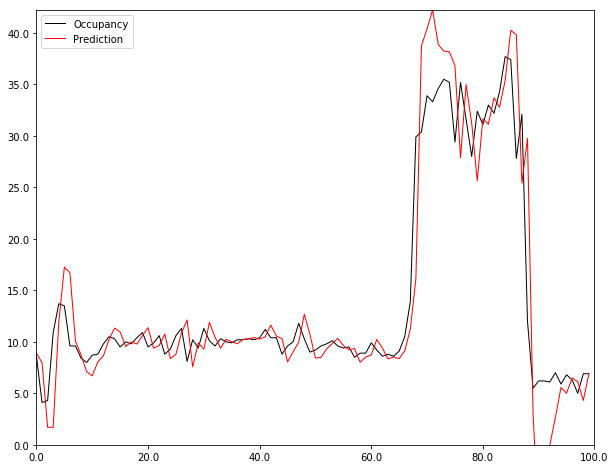

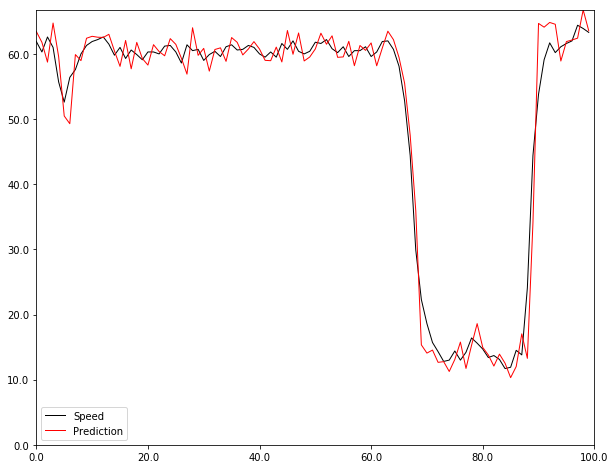

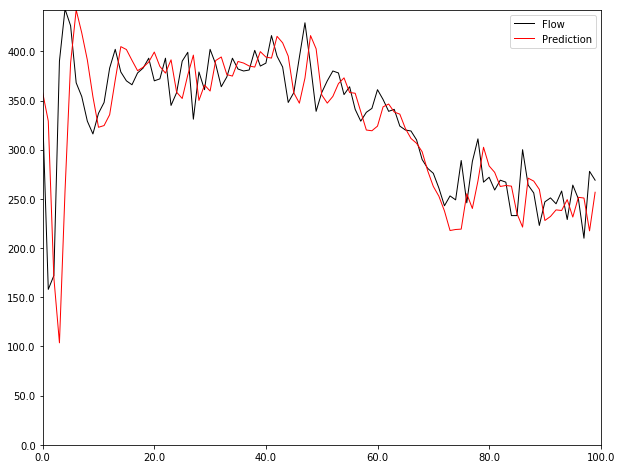

In [64]:
visualize_all(X[:, 1000:1100], best_Y[:, 1000:1100])

# Construct Positive and Negative Samples for SVM

$$ best\_Y\_list = [best\_Y\_B, best\_Y\_E] $$
$$normal\_train\_data\_list = [normal\_train\_data\_B, normal\_train\_data\_E]$$

The feature vector at time $t$ will look like this:
$$Z(m, n, t) = Z(0, 0, t) = [f(B, t-1), f(B, t), f(E, t-1), f(E, t)],$$
where $$f(i, t) = [X(i, t), Y(i, t), X(i, t) - Y(i, t)]^T.$$

Each vector $X, Y$ is denoted, same as before, as
$$X(i, t) = [occupancy, speed, flow]$$

We should have the following algorithms.

```
    ALGORITHM t_to_idx(df_S, t):
        return (idx of time t in df_S)
```

In [6]:
def t_to_idx(df_S, t):
    df_S_t = df_S.loc[(df_S["Date"] == t.date()) & (df_S["Time"] == t.time())]
    return None if df_S_t.empty else df_S_t.index.values[0]

```
    ALGORITHM construct_vector(X_S, idx):
        occupancy = X_S[idx]["occupancy"]
        speed = X_S[idx]["speed"]
        flow = X_S[idx]["flow"]
        return [occupancy, speed, flow]
```

In [7]:
def construct_vector(X_S, idx):
    return X_S[:, idx]

```
    ALGORITHM construct_f(df_S, X_S, Y_S, t):
        idx = t_to_idx(df_S, t)
        X_S_t = construct_vector(X_S, idx)
        Y_S_t = construct_vector(Y_S, idx)
        f_S_t = concatenation of X_S_t, Y_S_t, and X_S_t - Y_S_t
        return f_S_t
```

In [8]:
def construct_f(df_S, X_S, Y_S, t):
    f_S_t = np.array([])
    idx = t_to_idx(df_S, t)
    X_S_t = construct_vector(X_S, idx)
    Y_S_t = construct_vector(Y_S, idx)
    diff_X_Y = X_S_t - Y_S_t
    
    f_S_t = np.append(f_S_t, X_S_t)
    f_S_t = np.append(f_S_t, Y_S_t)
    f_S_t = np.append(f_S_t, diff_X_Y)
    
    return f_S_t

Construct feature for a road segment:
```
    ALGORITHM construct_feature(df_list, X_list, TSA_Y_list, t_list):
        z = empty vector
        for i, X in enumerate(X_list) do:
            for j, t in enumerate(t_list) do:
                z.append(construct_f(df_list[i], X, TSA_Y_list[i], t))
        return z
```

In [10]:
def construct_feature(df_list, X_list, TSA_Y_list, t_list):
    z = np.array([])
    for i, X in enumerate(X_list):
        for j, t in enumerate(t_list):
            z = np.append(z, construct_f(df_list[i], X, TSA_Y_list[i], t))
    return z

We also want a utility function, given $t$ and number of time lags $n$, generate a list of t with frequency of 5 minutes up to $(t - 5n)\ min$:

```
    ALGORITHM construct_t_list(t, num_lags):
        t_list = []
        for i from num_lags to 0 do:
            t_list.append(t - 5 * i  minutes)
        return t_list
```

In [11]:
def construct_t_list(t, num_lags):
    t_list = []
    for i in range(num_lags, -1, -1):
        t_list.append(t - datetime.timedelta(minutes=5*j))
    return t_list